<a href="https://colab.research.google.com/github/m-costantini/Set-wise_Coordinate_Descent/blob/master/main_a_dual_unfriendly_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code of Experiment D, a dual-unfriendly problem with no L knowledge, in "Set-wise Coordinate Descent for Dual Asynchronous Decentralized Optimization", Marina Costantini, Nikolaos Liakopoulos, Panayotis Mertikopoulos, Thrasyvoulos Spyropoulos, submitted to IEEE Transactions on Automatic Control

Author: Marina Costantini

marina.costantini@eurecom.fr

August 2023

In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time


# import profile
import cProfile

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Set-wise_Coordinate_Descent')
!cp -R -u -p /content/drive/MyDrive/Colab\ Notebooks/Set-wise_Coordinate_Descent/{decentralized_problems.py,decentralized_algorithms.py,functions.py} /content/
mods = ["decentralized_problems","decentralized_algorithms","functions"]
for mod_name in mods:
    if mod_name in sys.modules:
        del sys.modules[mod_name]

from decentralized_problems import LR_Problem
from decentralized_algorithms import SxCD
from functions import *

# General settings
fontsizes = {'ticks':14, 'legends':16, 'axes':18, 'titles':20, 'suptitles':22}


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Select seed for reproducibility
seed = 4397
print("seed =", seed)
np.random.seed(seed)

seed = 4397


### Make problem and run algorithms


In [5]:
"""'''''' Create the two graphs ''''''"""
n = 32
p_list = [0.1,0.5]

dim = 5


M = 30
steps_list = [6000 for i in range(len(p_list))]
# algos_to_run = ['SU-CD', 'SeL-CD', 'SGS-CD',  'SGSeL-CD']
algos_to_run = ['SeL-CD', 'SGSeL-CD']


G_list = []
for p in p_list:
    G_list.append( make_graph(n, 'random', p) )




"""'''''' Create problem and run algorithms ''''''"""

start_time = time.time()

results_primal = [None for i in range(len(G_list))]
results_dual = [None for i in range(len(G_list))]
opt_vals = [None for i in range(len(G_list))]
for idx_G, G in enumerate(G_list):

    print("Running graph", idx_G+1, "/", len(G_list))

    max_degree = np.max(np.sum(G,axis=1)) # maximum degree in the network
    A = get_edge_matrix(G)
    E = np.shape(A)[0]

    role, neighbors, N, nodes_edges = create_node_variables(A)
    mut_idcs, mat_edge_idxs, edge_to_nodes = create_edge_variables(A, neighbors)

    # generate problem
    the_problem = LR_Problem(n, A, dim, edge_to_nodes)
    opt_vals[idx_G] = the_problem.analy_opt_obj_val

    sz = 0.05
    stepsizes = [sz for i in range(E)] # for this experiment, fix all stepsizes to this value

    simu_vars = {'n': n,
                'dimensions': dim,
                'E': E,
                'A': A,
                'role': role,
                'neighbors': neighbors,
                'N': N,
                'mat_edge_idxs': mat_edge_idxs,
                'edge_to_nodes': edge_to_nodes,
                'nodes_edges': nodes_edges,
                'stepsizes': stepsizes,
                'mut_idcs': mut_idcs,
                'steps': steps_list[idx_G],
                'iteration_subsampling': 1}

    print("\nAnalytic opt val:", the_problem.analy_opt_obj_val)
    primal_obj_vals = {}
    dual_obj_vals = {}
    for algo in algos_to_run:
        print("\tRunning ", algo)
        the_solver = SxCD(the_problem, simu_vars, algo)
        primal_obj_vals[algo], dual_obj_vals[algo] = the_solver.solve()
        print("\t\tFinal value primal:", primal_obj_vals[algo][-1])
        print("\t\tFinal value dual:", dual_obj_vals[algo][-1], "\n")
    results_primal[idx_G] = primal_obj_vals
    results_dual[idx_G] = dual_obj_vals

end_time = time.time()
print('\n\nTime taken: ', end_time - start_time)


Running graph 1 / 2

Analytic opt val: 9.784416132033302
	Running  SeL-CD
		Final value primal: 9.784810217436338
		Final value dual: 9.784373829702753 

	Running  SGSeL-CD
Completed 57% --> Precision < 10^(-9) reached @ iter 3438  --> leave!
		Final value primal: 9.784421558822638
		Final value dual: 9.784416122397014 

Running graph 2 / 2

Analytic opt val: 9.784416132033302
	Running  SeL-CD
Completed 33% --> Precision < 10^(-9) reached @ iter 1998  --> leave!
		Final value primal: 9.78440824061757
		Final value dual: 9.784416122313521 

	Running  SGSeL-CD
Completed 12% --> Precision < 10^(-9) reached @ iter 775  --> leave!
		Final value primal: 9.784417034814231
		Final value dual: 9.784416125759497 



Time taken:  2099.6266524791718


### Plots

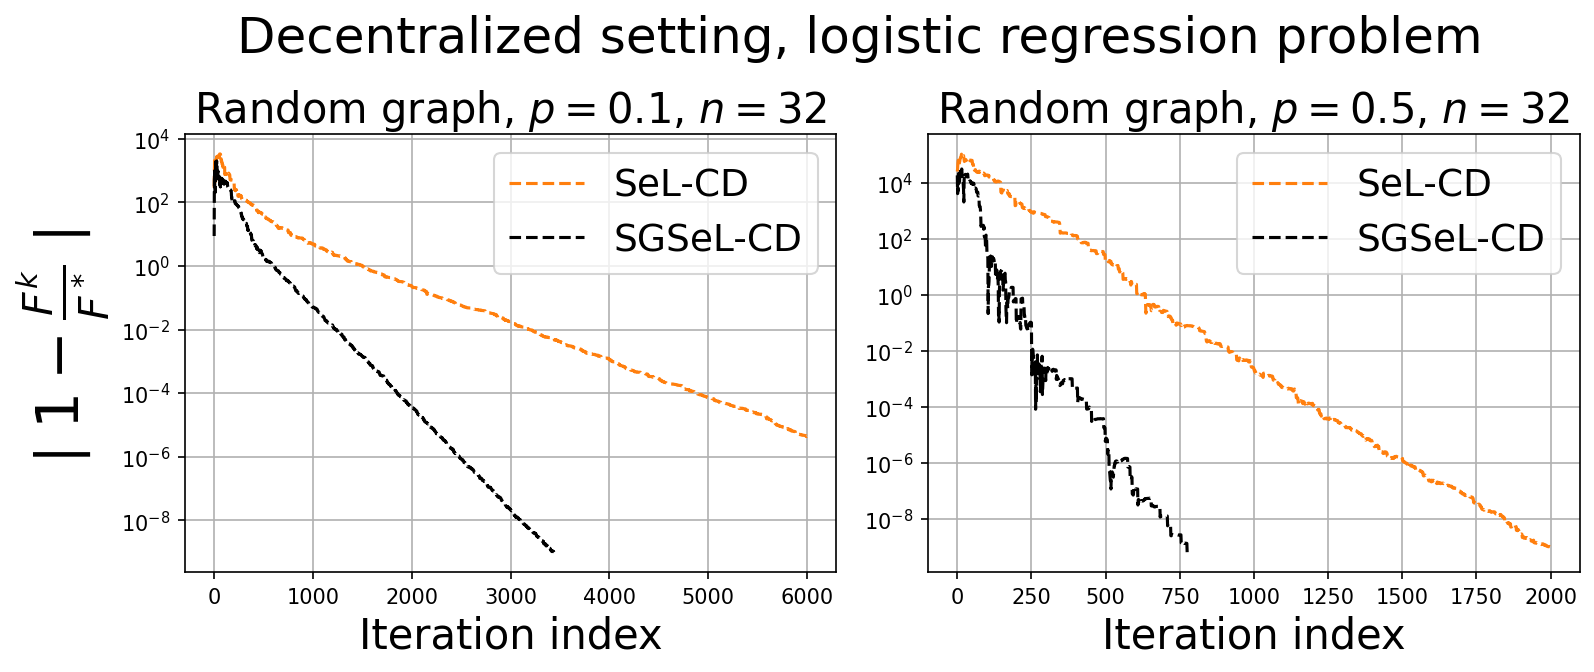

In [6]:
fontsz = {'legends':18, 'axes':20, 'titles':20, 'suptitles':24}

figsz = (6*len(G_list), 5)
color = {'SU-CD':'blue', 'SGS-CD':'red',
         'SL-CD':'C1', 'SGSL-CD':'black',
         'SeL-CD':'C1', 'SGSeL-CD':'black'}
linestyle = {'SU-CD':'-', 'SGS-CD':'-',
             'SL-CD':'-', 'SGSL-CD':'-',
             'SeL-CD':'--', 'SGSeL-CD':'--'}

"""'''''' Plots ''''''"""

fig, ax = plt.subplots(1, len(G_list), figsize=(6*len(G_list), 4), dpi=150)

for idx_G in range(len(G_list)):
    dual_obj_vals = results_dual[idx_G]
    for idx_algo, algo in enumerate(algos_to_run):
        suboptim = abs(1 - dual_obj_vals[algo]/opt_vals[idx_G])
        ax[idx_G].plot(suboptim, color=color[algo], linestyle=linestyle[algo], label=algo)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for idx_G in range(len(G_list)):
    ax[idx_G].set_xlabel('Iteration index', fontsize=fontsz['axes'])
    if idx_G == 0:
        ax[idx_G].set_ylabel(r'$ \mid 1 - \frac{F^k}{F^*} \mid $', fontsize=fontsz['axes']+8)
    ax[idx_G].grid()
    ax[idx_G].set_yscale("log")
    title_str = 'Random graph, ' + r'$p = $' + str(p_list[idx_G]) + r', $n = $' + str(n)
    ax[idx_G].set_title(title_str, fontsize=fontsz['titles'])
    ax[idx_G].legend(fontsize=fontsz['legends'])

suptitle_str = 'Decentralized setting, logistic regression problem'
fig.suptitle(suptitle_str, fontsize=fontsz['suptitles'])

fig.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.05,   # the bottom of the subplots of the figure
    top = 0.78,      # the top of the subplots of the figure
    wspace = 0.14,   # the amount of width reserved for blank space between subplots
    hspace = 0.1)   # the amount of height reserved for white space between subplots